# Traffic Management
### Grab AI for SEA Challenge

*Joao Valenciano*

---

### Executive Summary

Transport has been one of the main sectors of the Asian Development Bank (ADB) for decades. Road congestion in urban transport is one of their key priorities. Approximately, road congestion is costing 2%-5% of GDP Asian economies every year. As road construction has limitations and disadvantages, they have been piloting and testing several approaches to alleviate road congestion. One of these approaches is demand management, which seeks to limit congestion to improve traffic flows ([ADB](https://www.adb.org/sectors/transport/key-priorities/urban-transport), 2012).

In this notebook, we explored several deep learning methods to forecast the demand based on historical Grab booking data. We started with exploring more than 4 million bookings from the more than 1000 locations and found the uneven distribution of demand volume across the 61-day in the dataset. We, then, established the baseline error for our modeling. For demonstration, we selected `qp03wz`, as it is one of the busiest locations with the most number of the recorded volume. Demand management needs to prioritize locations like this. We also established a baseline model, which is a simple neural network, to benchmark the performance of the models. We explored 3 recurrent neural network (RNN) models: RNN with Gated Recurrent Unit (GRU), RNN with GRU and Dropout, and Stacked RNN-GRU with Dropout. RNN models perform well on sequential, temporal data. The best model that yielded the lowest validation loss of 0.74% was the RNN network with Gated Recurrent Unit (GRU). This model is also the least computationally expensive, which is more practical to handle the remaining locations.


### Load the Libraries and the Dataset
Let us load the libraries needed in this notebook and the demand dataset. We are naming the dataset as `traffic_df`.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

C:\Users\J2V\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
traffic_df = pd.read_csv('training.csv')

### Data Description

The dataset used here is from the Grab AI for SEA challenge on Traffic Management. From the [website](https://www.aiforsea.com/traffic-management), this is the Demand Data and contains the following:
* normalised historical demand of a city,
* aggregated spatiotemporally within geohashes and over 15 minute intervals,
* spans over a two month period

As described in the challenge, details of the data fields are as follows:

| Field | Description |
| :--- | :--- |
| geohash6 | geohash level 6 |
| | Geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa. Some examples include https://github.com/hkwi/python-geohash (for Python), https://github.com/kungfoo/geohash-java (for Java).|
| day | day, where the value indicates the sequential order and not a particular day of the month |
| timestamp | start time of 15-minute intervals, in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45) |
| demand | aggregated demand normalised to be in the range [0,1] |

### Exploratory Data Analysis

Let's start by looking at a snippet of the data.

In [3]:
traffic_df.head()

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

We can see that the contains alphanumeric strings, integers, time stamp, and float numbers.

#### The Size of the Dataset
Let's look at the size of the dataset.

In [4]:
traffic_df.shape

(4206321, 4)

There are more than 4 million rows of data available for this challenge.

#### The Data Types in the Dataset
Now, let us confirm the type of data available for each column.

In [5]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


We can see that day and demand are integers and floating numbers, respectively. However, geohash6 and timestamp column are string objects. Timestamp column needs to be converted to time data type.

In [6]:
traffic_df.timestamp = pd.to_datetime(traffic_df.timestamp,format='%H:%M').dt.time

#### Is There Any Missing Value?

Let us also check for any missing values in the data.

In [7]:
traffic_df.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

Based on the above result, we have no missing data in the dataframe.

#### The Demand Distribution
Since we are interested with the demand, we also check its distribution.

In [8]:
traffic_df.demand.describe()

count    4.206321e+06
mean     1.050907e-01
std      1.592655e-01
min      3.092217e-09
25%      1.867379e-02
50%      5.043463e-02
75%      1.208644e-01
max      1.000000e+00
Name: demand, dtype: float64

In [49]:
plt.figure(figsize=(10,6))
traffic_df.demand.plot.hist()
plt.xlabel('Demand Normalized Values')
plt.ylabel('Count of Instances')
plt.title('Most of the Demand are Far from the Maximum Value');

We can see that the majority of the demands are far from the maximum value. This could mean that most of the demands per interval are relatively comparable to each other.

#### Does All Locations Have the Same Number of Days?

Let us first check how many locations there are in the dataset.

In [10]:
len(traffic_df.geohash6.unique())

1329

There are 1,329 unique locations in the dataset.

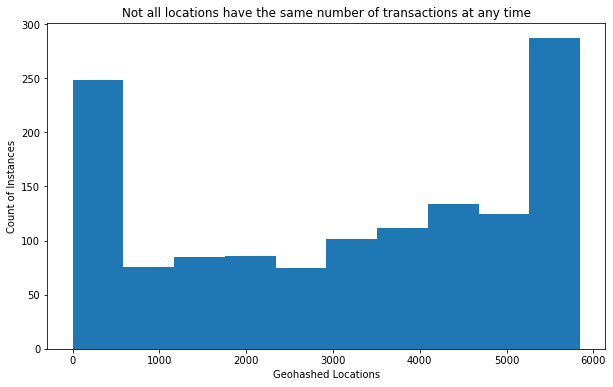

In [48]:
plt.figure(figsize=(10,6))
traffic_df.groupby(by=['geohash6'])['day'].count().plot.hist()
plt.xlabel('Geohashed Locations')
plt.ylabel('Count of Instances')
plt.title('Not all locations have the same number of transactions at any time');

However, not all locations have the same number of data points. This could mean that some locations have more demand or Grab booking and are busier than others. And this could also mean missing data for our time series.

#### There are Missing Values

Let's pivot our table to map our data with their corresponding day and time.

In [13]:
time_df = traffic_df.pivot_table(values='demand',index=['geohash6','day'],
                                 columns=['timestamp'])
time_df.head()

timestamp     00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
geohash6 day                                                               
qp02yc   1         NaN       NaN       NaN       NaN       NaN       NaN   
         2         NaN       NaN       NaN       NaN       NaN       NaN   
         3         NaN       NaN       NaN       NaN       NaN       NaN   
         4         NaN       NaN       NaN       NaN       NaN       NaN   
         5         NaN       NaN       NaN       NaN       NaN       NaN   

timestamp     01:30:00  01:45:00  02:00:00  02:15:00  ...  21:30:00  21:45:00  \
geohash6 day                                          ...                       
qp02yc   1         NaN       NaN       NaN       NaN  ...       NaN       NaN   
         2         NaN       NaN       NaN       NaN  ...       NaN       NaN   
         3         NaN       NaN       NaN       NaN  ...       NaN       NaN   
         4         NaN       NaN       NaN       NaN  ...       NaN       NaN   
         5         NaN       NaN       NaN       NaN  ...       NaN       NaN   

timestamp     22:00:00  22:15:00  22:30:00  22:45:00  23:00:00  23:15:00  \
geohash6 day                                                               
qp02yc   1         NaN       NaN       NaN       NaN       NaN       NaN   
         2         NaN       NaN       NaN  0.031419       NaN       NaN   
         3         NaN       NaN       NaN       NaN       NaN       NaN   
         4         NaN       NaN       NaN       NaN       NaN       NaN   
         5         NaN       NaN       NaN       NaN       NaN       NaN   

timestamp     23:30:00  23:45:00  
geohash6 day                      
qp02yc   1         NaN       NaN  
         2         NaN       NaN  
         3         NaN       NaN  
         4         NaN       NaN  
         5         NaN       NaN  

[5 rows x 96 columns]

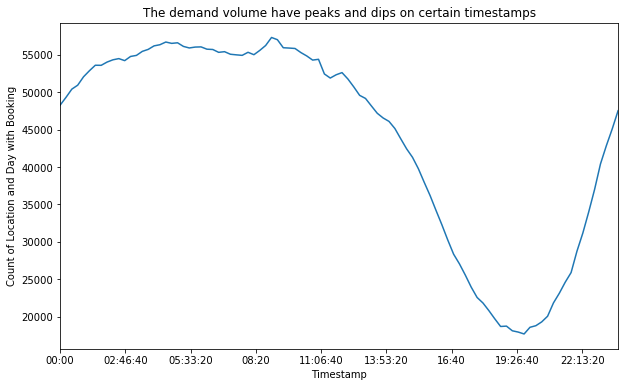

In [54]:
plt.figure(figsize=(10,6))
time_df.notnull().sum(axis=0).plot()
plt.xlabel('Timestamp')
plt.ylabel('Count of Location and Day with Booking')
plt.title('The demand volume have peaks and dips on certain timestamps');

#### The Location with Most Complete Data

For demonstration, let us select the busiest location and build our model from it.

In [14]:
time_df.groupby(by=['geohash6']).count().sum(axis=1).sort_values(ascending=False).head()

geohash6
qp03wz    5846
qp03xw    5846
qp03yb    5846
qp03wf    5846
qp09e5    5845
dtype: int64

#### The Missing Rows of Location `qp03wz`

A location with complete dataset has a total count of 5,856 (96 $\times$ 61) booking records. However, the top location, `qp03wz`, is lacking 10 days.

In [30]:
traffic_df[traffic_df.geohash6=='qp03wz'].pivot_table(
    values='demand',index=['geohash6','day'],columns=['timestamp']
).isnull().sum(axis=1).sum()

10

#### All Missing Values are in Day 18

Day 18 contains all the missing values. It seems that something happened that day, e.g. holiday, system outage/downtime, etc.

In [31]:
traffic_df[traffic_df.geohash6=='qp03wz'].pivot_table(
    values='demand',index=['geohash6','day'],columns=['timestamp']
).isnull().sum(axis=1)

geohash6  day
qp03wz    1       0
          2       0
          3       0
          4       0
          5       0
          6       0
          7       0
          8       0
          9       0
          10      0
          11      0
          12      0
          13      0
          14      0
          15      0
          16      0
          17      0
          18     10
          19      0
          20      0
          21      0
          22      0
          23      0
          24      0
          25      0
          26      0
          27      0
          28      0
          29      0
          30      0
                 ..
          32      0
          33      0
          34      0
          35      0
          36      0
          37      0
          38      0
          39      0
          40      0
          41      0
          42      0
          43      0
          44      0
          45      0
          46      0
          47      0
          48      0
          49      0
      

### Data Preparation

In [15]:
float_data = traffic_df[traffic_df.geohash6=='qp03wz'].pivot_table(values='demand',index=['geohash6','day'],columns=['timestamp']).values
float_data = float_data.reshape((61*96,1))

#### Plotting the Entire Dataset

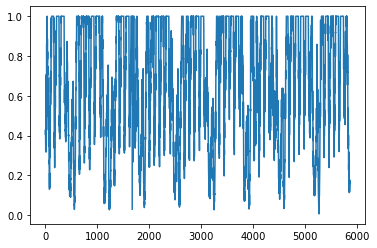

In [16]:
plt.plot(range(len(float_data)), float_data);

#### Plotting Day 18 with Missing Values
This is the plot for Day 18 with missing values.

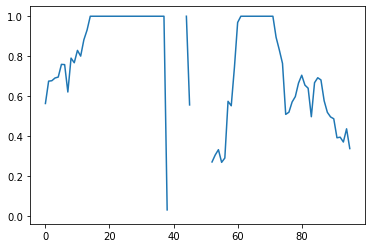

In [17]:
temp = float_data[96*17:96*18]  #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

#### Seasonality of 7 Days

Below is a 14-day dataset. It is very evident to see a recurrent pattern every 7 days.

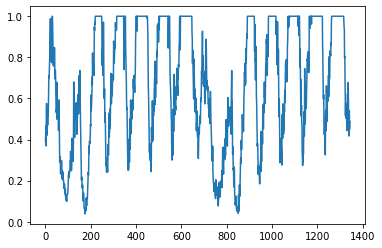

In [18]:
temp = float_data[96*18:96*32]  #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

#### Generator for Input and Target Data

In [19]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''
    Generate data for input sample and target for training and validation.
    
    Parameters:
    -----------
    data:     The original array of floating-point data.
    lookback: The timesteps count the input data should go back to.
    delay:    The timesteps count the target should be in the future.
    min_index and max_index: Indices in the data array that delimit which
              timesteps to draw from.
    shuffle: Whether to shuffle the samples or draw them in chronological order.
    batch_size: The number of samples per batch.
    step: The period, in timesteps, at which data is sampled.
    
    Returns:
    --------
    (samples, targets): tuple
    samples: The batch of input data.
    targets: The corresponding array of target
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

In [21]:
float_data_new = float_data[96*18:]

In [22]:
lookback = 672 # 7 days
step = 4 # 1 hr
delay = 96
batch_size = 128 # power of 2; faster way of utilizing the GPU

train_gen = generator(float_data_new,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=(96*24),
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data_new,
    lookback=lookback,
    delay=delay,
    min_index=(96*24)+1,
    max_index=(96*34),
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data_new,
    lookback=lookback,
    delay=delay,
    min_index=(96*34)+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = ((96*34) - (96*24)+1 - lookback)           #How many steps to draw from val_gen in order to see the entire 
                                                       #validation set
test_steps = (len(float_data) - (96*34)+1 - lookback)  #How many steps to draw from test_gen in order to see the 
                                                       #entire test set 

#### The Baseline Error

In [40]:
def evaluate_naive_method():
    batch_rmses = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1]
        rmse = np.sqrt(((preds - targets) ** 2).mean())
        batch_rmses.append(rmse)
    print(np.mean(batch_rmses))

evaluate_naive_method()

0.28712031241194796


Currently, the RMSE is at 0.287. The model should perform better than this baseline RMSE i.e. lower RMSE.

#### The Baseline Model: Simple Neural Networks

In [41]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data_new.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mse')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 0.0286 - val_loss: 0.0159
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0122 - val_loss: 0.0133
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.0091 - val_loss: 0.0246
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0075 - val_loss: 0.0218
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0066 - val_loss: 0.0251
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0059 - val_loss: 0.0139
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0050 - val_loss: 0.0190
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0047 - val_loss: 0.0133
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.004

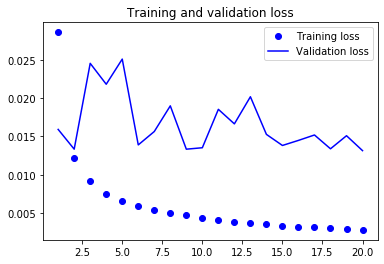

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

# plt.show();

From the above figure, we can see the overfitting of the training data that resulted to its big gap with the validation loss curves. This baseline model have more losses during validation and could be attributed to its poor generalization skill.

#### The RNN network with Gated Recurrent Unit (GRU) Model

In [43]:
model = Sequential()
model.add(layers.GRU(16, input_shape=(None, float_data_new.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mse')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/20
500/500 [==============================] - 79s 158ms/step - loss: 0.0639 - val_loss: 0.0212
Epoch 2/20
500/500 [==============================] - 82s 164ms/step - loss: 0.0410 - val_loss: 0.0555
Epoch 3/20
500/500 [==============================] - 82s 164ms/step - loss: 0.0361 - val_loss: 0.0232
Epoch 4/20
500/500 [==============================] - 85s 170ms/step - loss: 0.0289 - val_loss: 0.0160
Epoch 5/20
500/500 [==============================] - 81s 162ms/step - loss: 0.0200 - val_loss: 0.0260
Epoch 6/20
500/500 [==============================] - 82s 164ms/step - loss: 0.0159 - val_loss: 0.0079
Epoch 7/20
500/500 [==============================] - 82s 164ms/step - loss: 0.0140 - val_loss: 0.0098
Epoch 8/20
500/500 [==============================] - 80s 160ms/step - loss: 0.0125 - val_loss: 0.0095
Epoch 9/20
500/500 [==============================] - 83s 165ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 10/20
500/500 [==============================] - 81s 162ms/step - l

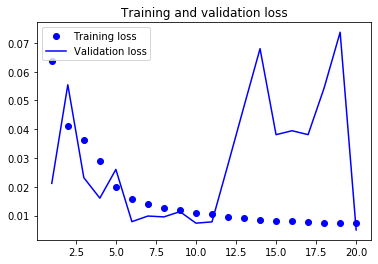

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


RNN GRU is a good model for sequential, temporal data. As from the figure, it performs better than the baseline. However, it also suffered from overfitting after the 11th epoch.

#### RNN Model with Dropout to Prevent Overfitting

Overfitting can be managed by regularization techniques. In deep learning, overfitting is a common regularization method to handle overfitting. We'll apply it in the next model.

In [37]:
model = Sequential()
model.add(layers.GRU(16,
                    dropout=0.1,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data_new.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mse')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=30,
                            validation_data=val_gen,
                            validation_steps=1000)

Epoch 1/30
500/500 [==============================] - 111s 221ms/step - loss: 0.0723 - val_loss: 0.0488
Epoch 2/30
500/500 [==============================] - 111s 223ms/step - loss: 0.0557 - val_loss: 0.0529
Epoch 3/30
500/500 [==============================] - 110s 219ms/step - loss: 0.0516 - val_loss: 0.0396
Epoch 4/30
500/500 [==============================] - 107s 214ms/step - loss: 0.0469 - val_loss: 0.0325
Epoch 5/30
500/500 [==============================] - 105s 209ms/step - loss: 0.0431 - val_loss: 0.0180
Epoch 6/30
500/500 [==============================] - 105s 211ms/step - loss: 0.0392 - val_loss: 0.0235
Epoch 7/30
500/500 [==============================] - 104s 209ms/step - loss: 0.0367 - val_loss: 0.0272
Epoch 8/30
500/500 [==============================] - 104s 207ms/step - loss: 0.0347 - val_loss: 0.0148
Epoch 9/30
500/500 [==============================] - 105s 209ms/step - loss: 0.0328 - val_loss: 0.0141
Epoch 10/30
500/500 [==============================] - 105s 210m

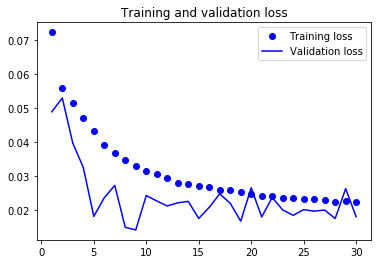

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

With the dropout added, we can see it really managed the overfitting in the dataset. The training and validation losses are comparable to each other. Although, near the end part of the training and validation, overfitting seems to creep in. We can also notice that the values are not as good as the previous GRU model. Also, the training time of this model is way longer than the previous model.

#### Stacked RNN Model

Let's try to stack this model with another RNN model and see if the losses could be brought lower.

In [51]:
model = Sequential()
model.add(layers.GRU(16,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data_new.shape[-1])))
model.add(layers.GRU(16, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.2))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mse')

history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=1000)

Epoch 1/20
500/500 [==============================] - 211s 421ms/step - loss: 0.0811 - val_loss: 0.0760
Epoch 2/20
500/500 [==============================] - 194s 388ms/step - loss: 0.0596 - val_loss: 0.0695
Epoch 3/20
500/500 [==============================] - 195s 390ms/step - loss: 0.0525 - val_loss: 0.0546
Epoch 4/20
500/500 [==============================] - 211s 421ms/step - loss: 0.0465 - val_loss: 0.0331
Epoch 5/20
500/500 [==============================] - 220s 441ms/step - loss: 0.0424 - val_loss: 0.0334
Epoch 6/20
500/500 [==============================] - 195s 389ms/step - loss: 0.0395 - val_loss: 0.0245
Epoch 7/20
500/500 [==============================] - 193s 387ms/step - loss: 0.0365 - val_loss: 0.0176
Epoch 8/20
500/500 [==============================] - 194s 389ms/step - loss: 0.0342 - val_loss: 0.0176
Epoch 9/20
500/500 [==============================] - 190s 379ms/step - loss: 0.0325 - val_loss: 0.0153
Epoch 10/20
500/500 [==============================] - 189s 378m

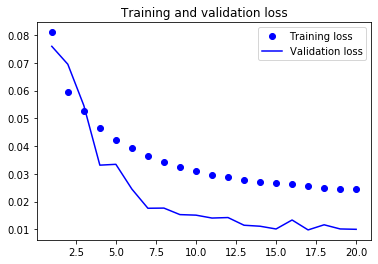

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

As we can see, the validation losses are lower than the previous model. It even seems that there is an underfitting in the model. The validation losses are lower than the training and it is far from overfitting. This can still be worked out. However, it also took a longer time to train compared to our first GRU model and the values of this model are also higher than that GRU model.

### Evaluation

Because of the performance of the RNN GRU model both in the validation loss and execution time, we will use that in the evaluation.

In [57]:
model = Sequential()
model.add(layers.GRU(16, input_shape=(None, float_data_new.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mse')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=8,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/8
500/500 [==============================] - 104s 208ms/step - loss: 0.0711 - val_loss: 0.0300
Epoch 2/8
500/500 [==============================] - 119s 238ms/step - loss: 0.0428 - val_loss: 0.0406
Epoch 3/8
500/500 [==============================] - 111s 223ms/step - loss: 0.0373 - val_loss: 0.0375
Epoch 4/8
500/500 [==============================] - 106s 211ms/step - loss: 0.0335 - val_loss: 0.0277
Epoch 5/8
500/500 [==============================] - 118s 237ms/step - loss: 0.0291 - val_loss: 0.0161
Epoch 6/8
500/500 [==============================] - 105s 209ms/step - loss: 0.0225 - val_loss: 0.0070
Epoch 7/8
500/500 [==============================] - 101s 202ms/step - loss: 0.0142 - val_loss: 0.0066
Epoch 8/8
500/500 [==============================] - 98s 196ms/step - loss: 0.0126 - val_loss: 0.0099


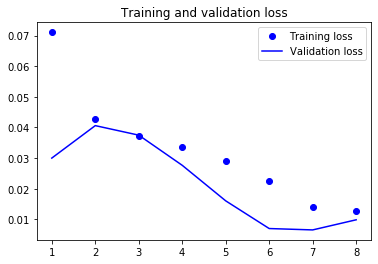

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [60]:
model.save('weights.h5')

In [61]:
from keras.models import load_model

model = load_model('weights.h5')

In [119]:
vg = []
for i in range(1000):
    vg.append(next(val_gen))
    
testg = []
for i in range(1000):
    testg.append(next(test_gen))

In [120]:
vg[0][0].shape

(128, 168, 1)

In [121]:
vg[0][1].shape

(128,)

In [122]:
pred1 = model.predict(vg[0][0])
pred2= model.predict(vg[1][0])

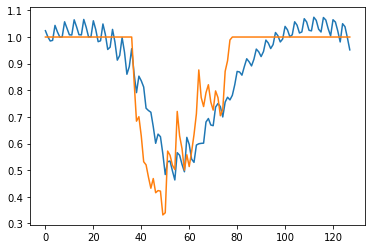

In [123]:
plt.plot(model.predict(vg[0][0]))
plt.plot(vg[0][1])

In [109]:
test_input = float_data_new[(96*35):(96*43)]

val_test = generator(test_input,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=None,
    step=step,
    batch_size=batch_size)

vg = []
for i in range(1000):
    vg.append(next(val_test))

In [124]:
pred1[:5]

array([[1.0237808 ],
       [1.0009669 ],
       [0.9850625 ],
       [0.98736405],
       [1.0436493 ]], dtype=float32)

In [125]:
vg[0][1][:5]

array([1., 1., 1., 1., 1.])

In [126]:
np.sqrt(((pred1[:5] - vg[0][1][:5]) ** 2).mean())

0.023893605231111188

### Acknowledgements

This notebook would not have been possible without the lecture of our professor in our MS program in Data Science. I would like to express my warmest gratitude to Dr. Christopher Monterola.